# Optimization Project - Runs file

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pickle

from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers
from tensorflow.random import set_seed


In [2]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.core.problem import Problem


from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice, Binary

from pymoo.operators.sampling.rnd import IntegerRandomSampling

from pymoo.util.display.column import Column
from pymoo.util.display.output import Output
from pymoo.core.callback import Callback

from pymoo.indicators.igd import IGD
from pymoo.indicators.hv import HV

from pymoo.algorithms.moo.moead import MOEAD
from pymoo.util.ref_dirs import get_reference_directions



## Load Data

In [3]:
# load the dataset
train_path = "classification_data_5_hand_gestures/train_data_norm.csv"
test_path = "classification_data_5_hand_gestures/test_data_norm.csv"
train_df = read_csv(train_path)
test_df = read_csv(test_path)

In [4]:
# Reduction and shuffle the data
train_df = train_df.iloc[:,1:]
test_df = test_df.iloc[:,1:]
train_data = pd.DataFrame(train_df.iloc[0,:])
test_data = pd.DataFrame(test_df.iloc[0,:])
train_data = train_data.T
test_data = test_data.T
for i in range(len(train_df)):
  if(i%30 == 0):
    train_data = train_data.append(train_df.iloc[i,:])
for j in range(len(test_df)):
  if(j%30 == 0):
    test_data = test_data.append(test_df.iloc[j,:])
train_data = train_data.iloc[1:,:]
test_data = test_data.iloc[1:,:]
#shuffle:
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)
# train data = 1000 samples
# test data = 250 samples

In [5]:
# encode the data
X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values

X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1000, 28) (1000,) (250, 28) (250,)


## Objective Function

In [6]:
# Objective Function - build neural network, fit the net, and check accuracy on test data
def obj_func(n_first_layer ,n_hidden ,s_hidden): 
  set_seed(5)
  # define model
  model = Sequential()
  model.add(Dense(n_first_layer, input_dim=28, activation='relu', input_shape=(28,))) #,kernel_initializer=initializers.Zeros
  for i in range(n_hidden):
    model.add(Dense(s_hidden, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  # model.summary()
  trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
  nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
  totalParams = trainableParams + nonTrainableParams

  # compile the model
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
  # fit the model
  model.fit(X_train, y_train, epochs=50, batch_size=20, verbose=0)
  # evaluate the model
  loss, acc = model.evaluate(X_test, y_test, verbose=0)
  
  return(totalParams,round(acc*100,2))


In [7]:
#### for check - check the variance between runs
# for j in range(1):
#   # for k in range(5):
#     n_hidden = 1
#     s_hidden = 1
#     n_first_layer = 1 
#     # s_first_layer = 5
#     num_of_param, acc = obj_func(n_first_layer,n_hidden,s_hidden)
#     print(n_first_layer,n_hidden,s_hidden)
#     print(num_of_param,acc)

## Define utility classes

In [8]:
# print in every iteration at the minimize
class MyOutput(Output):

    def __init__(self):
        super().__init__()
        self.acc_ = Column("best acc", width=10)
        self.acc_w = Column("worst acc", width=10)
        self.par_ = Column("best params", width=10)
        self.par_w = Column("worst params", width=10)
        self.columns += [self.acc_, self.acc_w, self.par_, self.par_w]

    def update(self, algorithm):
        super().update(algorithm)
        res = algorithm.pop.get("F")
        res = np.round(res, 2)
        self.acc_.set(f'{np.min(res[:,0]):.2f}')
        self.acc_w.set(f'{np.max(res[:,0]):.2f}')
        self.par_.set(f'{np.min(res[:,1]):.0f}')
        self.par_w.set(f'{np.max(res[:,1]):.0f}')
        plt.scatter(res[:,0],res[:,1])
        plt.draw() # show()


In [9]:
# save data for plots after the minimize
class MyCallback(Callback):

    def __init__(self) -> None:
        super().__init__()
        self.data["best"] = []
        self.index = 1
        self.data_history = pd.DataFrame(columns=['Gen' ,'Design_1', 'Design_2', 'Design_3', 'Objective_1', 'Objective_2'])

    def notify(self, algorithm):
        self.data["best"].append(algorithm.pop.get("F").min())
        self.data_history = self.data_history.append({'Gen': self.index, 'Design_1':  np.round(algorithm.pop.get("X")[:,0],0),
                                                      'Design_2':  np.round(algorithm.pop.get("X")[:,1],0),
                                                      'Design_3':  np.round(algorithm.pop.get("X")[:,2],0),
                                                      'Objective_1':  algorithm.pop.get("F")[:,0],
                                                      'Objective_2':  algorithm.pop.get("F")[:,1]}, ignore_index=True)
        self.index = self.index + 1


## Define The Problem

* design parameters = n_hidden [1,50] , s_hidden[1,100]

* objective = total parameters[431,<500K] , accuracy[0,100]

In [10]:
# problem class
class Net_Struct_Problem(Problem):
      def __init__(self, **kwargs):
          super().__init__(n_var=3, n_obj=2, n_ieq_constr=0,xl=[1, 1, 1], xu=[14,50,100], vtype=int)
          
      def _evaluate(self, X, out, *args, **kwargs):
          num_params = []
          acc_ = []
          X = np.round(X)
          for x in X:
            f, n, s = int(x[0]), int(x[1]), int(x[2])
            t_param, acc = obj_func(f, n, s)
            acc_.append(acc)
            num_params.append(t_param)
          acc_ = np.array(acc_)
          num_params = np.array(num_params)
          out['F'] =  [-acc_, num_params]


## Define algorithm parameters

In [11]:
num_of_generations = 10
population_size = 30
# (10*30 = 27min nsga2, = 31min moead)
# (10*40 = min nsga2, = min moead)

## Run The Algorithms

### NSGA2

In [11]:
def nsga_():
  num_of_generations = 40
  population_size = 160
  problem = Net_Struct_Problem()

  algorithm_n = NSGA2(pop_size=population_size)

  stop_criteria = ('n_gen', num_of_generations)

  results_NSGA2 = minimize(
      problem=problem,
      algorithm=algorithm_n,
      callback=MyCallback(),
      output=MyOutput(),
      termination=stop_criteria,
      save_history=True,
      verbose=True
  )
  return results_NSGA2


### MOEAD

In [13]:
def moead_():  
  num_of_generations = 10
  population_size = 30
  stop_criteria = ('n_gen', num_of_generations)
  
  problem = Net_Struct_Problem()

  ref_dirs = get_reference_directions("uniform", 2, n_partitions=29)

  algorithm_m = MOEAD(
      ref_dirs,
      n_neighbors=15,
      prob_neighbor_mating=0.7,
  )

  results_MOEAD = minimize(problem,
                algorithm_m,
                termination=stop_criteria,
                # seed=1,
                callback=MyCallback(),
                save_history=True,
                verbose=True)

  Scatter().add(results_MOEAD.F).show()
  return results_MOEAD

n_gen  |  n_eval  |  best acc  | worst acc  | best params | worst params
     1 |      120 |     -95.60 |     -20.00 |        147 |     421707
     2 |      240 |     -98.00 |     -20.00 |        147 |     251962
     3 |      360 |     -98.00 |     -20.00 |        125 |     251962
     4 |      480 |     -98.00 |     -20.00 |         66 |     251962
     5 |      600 |     -98.00 |     -20.00 |         66 |     251962
     6 |      720 |     -98.00 |     -20.00 |         48 |     251962
     7 |      840 |     -98.00 |     -20.00 |         48 |     251962
     8 |      960 |     -98.00 |     -20.00 |         45 |     251962
     9 |     1080 |     -98.00 |     -20.00 |         45 |     251962
    10 |     1200 |     -98.80 |     -20.00 |         41 |     251962
    11 |     1320 |     -98.80 |     -20.00 |         41 |     251962
    12 |     1440 |     -98.80 |     -20.00 |         41 |     251962
    13 |     1560 |     -98.80 |     -20.00 |         41 |     251962
    14 |     1680

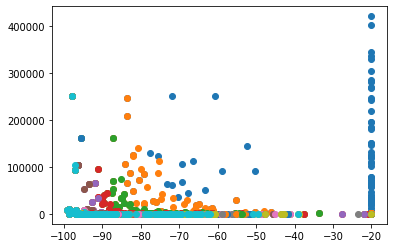

In [14]:
for i in range(1):
  results_NSGA2 = nsga_() 
  # results_MOEAD = moead_()
  # Save the object to a file using pickle
  with open(f'res_nsga_long_run_3.pkl', 'wb') as f:
    pickle.dump(results_NSGA2, f)

  # with open(f'res_moead_{i+21}.pkl', 'wb') as l:
  #   pickle.dump(results_MOEAD, l)

In [19]:
print(results_NSGA2.exec_time/60)
print(results_MOEAD.exec_time/60)

30.34190300703049
20.521171581745147


## Results

### NSGA2 Result

In [ ]:
# results_NSGA2.pop.get("F")

In [ ]:
# val = results_NSGA2.algorithm.callback.data_history
# val

In [ ]:
def from_pymoo_to_des_obj(results): # (for gen 1)
  des_1 = results.algorithm.callback.data_history['Design_1']
  des_1 = des_1[0][:]
  des_2 = results.algorithm.callback.data_history['Design_2']
  des_2 = des_2[0][:]
  des_3 = results.algorithm.callback.data_history['Design_3']
  des_3 = des_3[0][:]
  obj_1 = results.algorithm.callback.data_history['Objective_1']
  obj_1 = obj_1[0][:]
  obj_2 = results.algorithm.callback.data_history['Objective_2']
  obj_2 = obj_2[0][:]
  return des_1,des_2,des_3,obj_1,obj_2

In [ ]:
des_1,des_2,des_3,obj_1,obj_2 = from_pymoo_to_des_obj(results_NSGA2) 

In [ ]:
# Create the figure and axes for the 3D plot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(des_1, des_2, des_3,color=['blue'], marker="s")
ax.set_xlabel('Size first layer',fontsize=16)
ax.set_ylabel('Number hidden layers',fontsize=16)
ax.set_zlabel('Size hidden layers',fontsize=16)
ax.set_title('Design Space',fontsize=20) #NSGA2\n
# plt.savefig('nsga_des.png')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(obj_1,obj_2, color=['blue'])
ax.set_xlabel('-Accuracy[%]',fontsize=16)
ax.set_ylabel('Number of parameters',fontsize=16)
ax.set_title('Objective Space',fontsize=20)
# plt.savefig('nsga_obj.png')
plt.show()

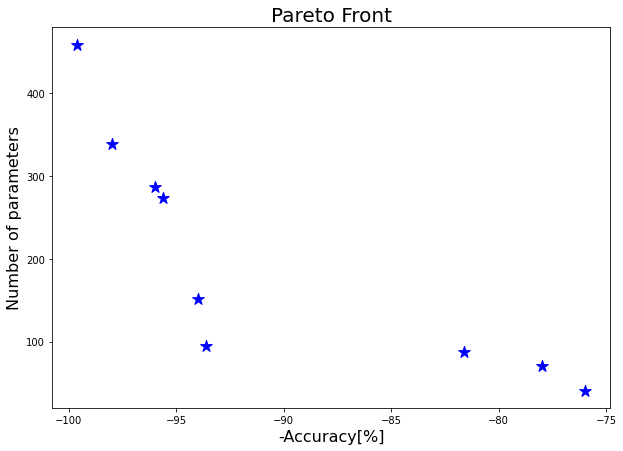

In [13]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(results_NSGA2.F[:,0],results_NSGA2.F[:,1], color=['blue'], marker="*", s=150)
ax.set_xlabel('-Accuracy[%]',fontsize=16)
ax.set_ylabel('Number of parameters',fontsize=16)
ax.set_title('Pareto Front',fontsize=20)
# plt.savefig('nsga_pareto.png')
plt.show()

### MOEAD Results

In [ ]:
# val = results_MOEAD.algorithm.callback.data_history
# val

In [ ]:
des_1,des_2,des_3,obj_1,obj_2 = from_pymoo_to_des_obj(results_MOEAD) 

In [ ]:
# Create the figure and axes for the 3D plot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(des_1, des_2, des_3,color=['red'], marker="s")
ax.set_xlabel('Size first layer',fontsize=16)
ax.set_ylabel('Number hidden layers',fontsize=16)
ax.set_zlabel('Size hidden layers',fontsize=16)
ax.set_title('Design Space',fontsize=20)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(obj_1,obj_2, color=['red'])
ax.set_xlabel('-Accuracy[%]',fontsize=16)
ax.set_ylabel('Number of parameters',fontsize=16)
ax.set_title('Objective Space',fontsize=20)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(results_MOEAD.F[:,0],results_MOEAD.F[:,1], color=['red'], marker="*", s=150)
ax.set_xlabel('-Accuracy[%]',fontsize=16)
ax.set_ylabel('Number of parameters',fontsize=16)
ax.set_title('Pareto Front',fontsize=20)
plt.show()

## Save Results

In [ ]:
# # Save the object to a file using pickle
# with open('res_nsga_4.pkl', 'wb') as f:
#   pickle.dump(results_NSGA2, f)

# with open('res_moead_4.pkl', 'wb') as l:
#   pickle.dump(results_MOEAD, l)


In [ ]:
# # Load the object from the file using pickle
# with open('res_nsga_4.pkl', 'rb') as f:
#   loaded_nsga_data = pickle.load(f)
# with open('res_moead_4.pkl', 'rb') as l:
#   loaded_moead_data = pickle.load(l)


In [ ]:
# loaded_nsga_data.algorithm.callback.data_history

In [ ]:
# loaded_moead_data.algorithm.callback.data_history

In [6]:
## Run algo with 4 des and 3 obj


# Objective Function - build neural network, fit the net, and check accuracy on test data
def obj_func_2(n_first_layer ,n_hidden ,s_hidden, n_epochs): 
  set_seed(5)
  # define model
  model = Sequential()
  model.add(Dense(n_first_layer, input_dim=28, activation='relu', input_shape=(28,))) #,kernel_initializer=initializers.Zeros
  for i in range(n_hidden):
    model.add(Dense(s_hidden, activation='relu'))
  model.add(Dense(5, activation='softmax'))
  # model.summary()
  trainableParams = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
  nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
  totalParams = trainableParams + nonTrainableParams

  # compile the model
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
  # fit the model
  model.fit(X_train, y_train, epochs=n_epochs, batch_size=20, verbose=0)
  # evaluate the model
  loss, acc = model.evaluate(X_test, y_test, verbose=0)
  
  return(totalParams, round(acc*100,2), n_epochs)


# #### for check - check the variance between runs
# for j in range(1):
#   # for k in range(5):
#     n_hidden = 2
#     s_hidden = 10
#     s_first_layer = 3 
#     n_epochs = 3

#     num_of_param, acc, n_e = obj_func_2(s_first_layer,n_hidden,s_hidden,n_epochs)
#     print(s_first_layer,n_hidden,s_hidden, n_e)
#     print(num_of_param,acc, n_e)

# print in every iteration at the minimize
class MyOutput_2(Output):

    def __init__(self):
        super().__init__()
        self.acc_ = Column("best acc", width=10)
        self.acc_w = Column("worst acc", width=10)
        self.par_ = Column("best params", width=10)
        self.par_w = Column("worst params", width=10)
        self.ep_ = Column("best epochs", width=10)
        self.ep_w = Column("worst epochs", width=10)
        self.columns += [self.acc_, self.acc_w, self.par_, self.par_w, self.ep_, self.ep_w]

    def update(self, algorithm):
        super().update(algorithm)
        res = algorithm.pop.get("F")
        res = np.round(res, 2)
        self.acc_.set(f'{np.min(res[:,0]):.2f}')
        self.acc_w.set(f'{np.max(res[:,0]):.2f}')
        self.par_.set(f'{np.min(res[:,1]):.0f}')
        self.par_w.set(f'{np.max(res[:,1]):.0f}')
        self.ep_.set(f'{np.min(res[:,2]):.0f}')
        self.ep_w.set(f'{np.max(res[:,2]):.0f}')
        # plt.scatter(res[:,0],res[:,1])
        # plt.draw() # show()


# save data for plots after the minimize
class MyCallback_2(Callback):

    def __init__(self) -> None:
        super().__init__()
        self.data["best"] = []
        self.index = 1
        self.data_history = pd.DataFrame(columns=['Gen' ,'Design_1', 'Design_2', 'Design_3', 'Design_4', 'Objective_1', 'Objective_2', 'Objective_3'])

    def notify(self, algorithm):
        self.data["best"].append(algorithm.pop.get("F").min())
        self.data_history = self.data_history.append({'Gen': self.index, 'Design_1':  np.round(algorithm.pop.get("X")[:,0],0),
                                                      'Design_2':  np.round(algorithm.pop.get("X")[:,1],0),
                                                      'Design_3':  np.round(algorithm.pop.get("X")[:,2],0),
                                                      'Design_4':  np.round(algorithm.pop.get("X")[:,3],0),
                                                      'Objective_1':  algorithm.pop.get("F")[:,0],
                                                      'Objective_2':  algorithm.pop.get("F")[:,1],
                                                      'Objective_3':  algorithm.pop.get("F")[:,2]}, ignore_index=True)
        self.index = self.index + 1


# problem class
class Net_Struct_Problem_2(Problem):
      def __init__(self, **kwargs):
          super().__init__(n_var=4, n_obj=3, n_ieq_constr=0,xl=[3, 1, 1, 1], xu=[50, 14,50,100], vtype=int)
          
      def _evaluate(self, X, out, *args, **kwargs):
          num_params = []
          acc_ = []
          ep_ = []
          X = np.round(X)
          for x in X:
            e, f, n, s = int(x[0]), int(x[1]), int(x[2]), int(x[3])
            t_param, acc, ep = obj_func_2(f, n, s, e)
            acc_.append(acc)
            num_params.append(t_param)
            ep_.append(ep)
          acc_ = np.array(acc_)
          num_params = np.array(num_params)
          ep_ = np.array(ep_)
          out['F'] =  [-acc_, num_params, ep_]



def get_obj(res, i):  
  ddes_1 = res.algorithm.callback.data_history['Design_1']
  ddes_1 = ddes_1[i][:]
  ddes_2 = res.algorithm.callback.data_history['Design_2']
  ddes_2 = ddes_2[i][:]
  ddes_3 = res.algorithm.callback.data_history['Design_3']
  ddes_3 = ddes_3[i][:]
  ddes_4 = res.algorithm.callback.data_history['Design_4']
  ddes_4 = ddes_4[i][:]
  oobj_1 = res.algorithm.callback.data_history['Objective_1']
  oobj_1 = oobj_1[i][:]
  oobj_2 = res.algorithm.callback.data_history['Objective_2']
  oobj_2 = oobj_2[i][:]
  oobj_3 = res.algorithm.callback.data_history['Objective_3']
  oobj_3 = oobj_3[i][:]
  return oobj_1, oobj_2, oobj_3






In [11]:
problem_2 = Net_Struct_Problem_2()

algorithm_n_2 = NSGA2(pop_size=120) # 120*20 , 60*5= 50min

stop_criteria_2 = ('n_gen', 20)

results_NSGA2_3_obj = minimize(
    problem=problem_2,
    algorithm=algorithm_n_2,
    callback=MyCallback_2(),
    output=MyOutput_2(),
    termination=stop_criteria_2,
    save_history=True,
    verbose=True
)

n_gen  |  n_eval  |  best acc  | worst acc  | best params | worst params | best epochs | worst epochs
     1 |      120 |     -92.80 |     -20.00 |        578 |     496924 |          3 |         50
     2 |      240 |     -92.80 |     -20.00 |        163 |     272129 |          3 |         48
     3 |      360 |     -94.80 |     -20.00 |         78 |     246681 |          3 |         47
     4 |      480 |     -94.80 |     -20.00 |         78 |     246071 |          3 |         47
     5 |      600 |     -94.80 |     -20.00 |         51 |     246071 |          3 |         48
     6 |      720 |     -94.80 |     -19.60 |         51 |     231599 |          3 |         48
     7 |      840 |     -94.80 |     -20.00 |         51 |     231599 |          3 |         48
     8 |      960 |     -94.80 |     -20.00 |         49 |     231599 |          3 |         48
     9 |     1080 |     -94.80 |     -17.20 |         48 |     231599 |          3 |         48
    10 |     1200 |     -96.80 |  

In [ ]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(131,projection='3d')
oobj_1, oobj_2, oobj_3 = get_obj(results_NSGA2_3_obj, 4)
ax.scatter(oobj_1, oobj_2, oobj_3,color=['black'])
# ax.set_xlabel('-Accuracy[%]',fontsize=4)
# ax.set_ylabel('Number of parameters',fontsize=4)
# ax.set_zlabel('Number of epochs',fontsize=4)
ax.set_title('Objective Space gen 5',fontsize=12)
ax2 = fig.add_subplot(132,projection='3d')
oobj_1, oobj_2, oobj_3 = get_obj(results_NSGA2_3_obj, 2)
ax2.scatter(oobj_1, oobj_2, oobj_3,color=['black'])
ax2.set_title('Objective Space gen 3',fontsize=12)
ax3 = fig.add_subplot(133,projection='3d')
oobj_1, oobj_2, oobj_3 = get_obj(results_NSGA2_3_obj, 0)
ax3.scatter(oobj_1, oobj_2, oobj_3,color=['black'])
ax3.set_title('Objective Space gen 1',fontsize=12)


plt.show()

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(results_NSGA2_3_obj.F[:,0],results_NSGA2_3_obj.F[:,1], results_NSGA2_3_obj.F[:,2],color=['black'], marker="*")
ax.set_xlabel('-Accuracy[%]',fontsize=16)
ax.set_ylabel('Number of parameters',fontsize=16)
ax.set_zlabel('Number of epochs',fontsize=16)
ax.set_title('Pareto Front',fontsize=20)

plt.show()

In [12]:

with open(f'res_nsga_3_obj.pkl', 'wb') as f:
    pickle.dump(results_NSGA2_3_obj, f)

  # with open(f'res_moead_{i+21}.pkl', 'wb') as l:
  #   pickle.dump(results_MOEAD, l)

In [14]:
with open('res_nsga_3_obj.pkl', 'rb') as f:
  loaded_data = pickle.load(f)
loaded_data.algorithm.callback.data_history

,Gen,Design_1,Design_2,Design_3,Design_4,Objective_1,Objective_2,Objective_3
0,1,"[12.0, 23.0, 38.0, 4.0, 32.0, 5.0, 29.0, 16.0,...","[2.0, 7.0, 9.0, 11.0, 3.0, 8.0, 12.0, 6.0, 10....","[1.0, 15.0, 4.0, 19.0, 1.0, 21.0, 6.0, 15.0, 5...","[94.0, 5.0, 10.0, 77.0, 54.0, 8.0, 60.0, 43.0,...","[-66.8, -20.0, -81.6, -74.0, -79.6, -47.2, -79...","[815.0, 693.0, 746.0, 109741.0, 578.0, 1789.0,...","[12.0, 23.0, 38.0, 4.0, 32.0, 5.0, 29.0, 16.0,..."
1,2,"[12.0, 38.0, 4.0, 32.0, 5.0, 16.0, 35.0, 8.0, ...","[2.0, 9.0, 11.0, 3.0, 8.0, 6.0, 10.0, 10.0, 9....","[1.0, 4.0, 19.0, 1.0, 21.0, 15.0, 5.0, 10.0, 5...","[94.0, 10.0, 77.0, 54.0, 8.0, 43.0, 17.0, 87.0...","[-66.8, -81.6, -74.0, -79.6, -47.2, -92.8, -88...","[815.0, 746.0, 109741.0, 578.0, 1789.0, 27183....","[12.0, 38.0, 4.0, 32.0, 5.0, 16.0, 35.0, 8.0, ..."
2,3,"[12.0, 38.0, 4.0, 32.0, 16.0, 35.0, 8.0, 12.0,...","[2.0, 9.0, 11.0, 3.0, 6.0, 10.0, 10.0, 3.0, 2....","[1.0, 4.0, 19.0, 1.0, 15.0, 5.0, 10.0, 1.0, 12...","[94.0, 10.0, 77.0, 54.0, 43.0, 17.0, 87.0, 94....","[-66.8, -81.6, -74.0, -79.6, -92.8, -88.8, -88...","[815.0, 746.0, 109741.0, 578.0, 27183.0, 1791....","[12.0, 38.0, 4.0, 32.0, 16.0, 35.0, 8.0, 12.0,..."
3,4,"[38.0, 4.0, 32.0, 16.0, 35.0, 8.0, 12.0, 42.0,...","[9.0, 11.0, 3.0, 6.0, 10.0, 10.0, 3.0, 9.0, 4....","[4.0, 19.0, 1.0, 15.0, 5.0, 10.0, 1.0, 2.0, 2....","[10.0, 77.0, 54.0, 43.0, 17.0, 87.0, 94.0, 7.0...","[-81.6, -74.0, -79.6, -92.8, -88.8, -88.4, -75...","[746.0, 109741.0, 578.0, 27183.0, 1791.0, 7059...","[38.0, 4.0, 32.0, 16.0, 35.0, 8.0, 12.0, 42.0,..."
4,5,"[12.0, 7.0, 8.0, 7.0, 40.0, 8.0, 7.0, 22.0, 14...","[3.0, 9.0, 9.0, 2.0, 9.0, 9.0, 5.0, 12.0, 3.0,...","[1.0, 5.0, 11.0, 15.0, 5.0, 4.0, 15.0, 31.0, 1...","[94.0, 10.0, 23.0, 2.0, 6.0, 7.0, 24.0, 87.0, ...","[-75.2, -62.4, -82.0, -20.0, -86.0, -61.2, -85...","[938.0, 856.0, 6131.0, 163.0, 524.0, 539.0, 88...","[12.0, 7.0, 8.0, 7.0, 40.0, 8.0, 7.0, 22.0, 14..."
5,6,"[12.0, 40.0, 7.0, 22.0, 14.0, 19.0, 12.0, 39.0...","[3.0, 9.0, 5.0, 12.0, 3.0, 12.0, 10.0, 9.0, 6....","[1.0, 5.0, 15.0, 31.0, 1.0, 1.0, 1.0, 4.0, 7.0...","[94.0, 6.0, 24.0, 87.0, 93.0, 22.0, 94.0, 10.0...","[-75.2, -86.0, -85.6, -94.8, -86.8, -86.8, -80...","[938.0, 524.0, 8814.0, 231599.0, 929.0, 749.0,...","[12.0, 40.0, 7.0, 22.0, 14.0, 19.0, 12.0, 39.0..."
6,7,"[12.0, 40.0, 22.0, 14.0, 12.0, 5.0, 47.0, 47.0...","[3.0, 9.0, 12.0, 3.0, 10.0, 6.0, 3.0, 11.0, 9....","[1.0, 5.0, 31.0, 1.0, 1.0, 7.0, 1.0, 2.0, 4.0,...","[94.0, 6.0, 87.0, 93.0, 94.0, 3.0, 53.0, 3.0, ...","[-75.2, -86.0, -94.8, -86.8, -80.4, -48.0, -92...","[938.0, 524.0, 231599.0, 929.0, 1799.0, 287.0,...","[12.0, 40.0, 22.0, 14.0, 12.0, 5.0, 47.0, 47.0..."
7,8,"[22.0, 14.0, 5.0, 3.0, 16.0, 22.0, 21.0, 5.0, ...","[12.0, 3.0, 6.0, 9.0, 6.0, 2.0, 1.0, 9.0, 3.0,...","[31.0, 1.0, 7.0, 4.0, 1.0, 1.0, 6.0, 4.0, 2.0,...","[87.0, 93.0, 3.0, 58.0, 43.0, 2.0, 1.0, 77.0, ...","[-94.8, -86.8, -48.0, -84.8, -80.4, -66.4, -20...","[231599.0, 929.0, 287.0, 11402.0, 695.0, 79.0,...","[22.0, 14.0, 5.0, 3.0, 16.0, 22.0, 21.0, 5.0, ..."
8,9,"[22.0, 14.0, 3.0, 22.0, 21.0, 5.0, 3.0, 21.0, ...","[12.0, 3.0, 9.0, 2.0, 1.0, 9.0, 3.0, 2.0, 6.0,...","[31.0, 1.0, 4.0, 1.0, 6.0, 4.0, 2.0, 2.0, 5.0,...","[87.0, 93.0, 58.0, 2.0, 1.0, 77.0, 97.0, 2.0, ...","[-94.8, -86.8, -84.8, -66.4, -20.0, -93.6, -76...","[231599.0, 929.0, 11402.0, 79.0, 51.0, 19439.0...","[22.0, 14.0, 3.0, 22.0, 21.0, 5.0, 3.0, 21.0, ..."
9,10,"[22.0, 14.0, 3.0, 22.0, 5.0, 3.0, 21.0, 7.0, 3...","[12.0, 3.0, 9.0, 2.0, 9.0, 3.0, 2.0, 6.0, 11.0...","[31.0, 1.0, 4.0, 1.0, 4.0, 2.0, 2.0, 5.0, 5.0,...","[87.0, 93.0, 58.0, 2.0, 77.0, 97.0, 2.0, 7.0, ...","[-94.8, -86.8, -84.8, -66.4, -93.6, -76.0, -50...","[231599.0, 929.0, 11402.0, 79.0, 19439.0, 1047...","[22.0, 14.0, 3.0, 22.0, 5.0, 3.0, 21.0, 7.0, 3..."
